In [1]:
from math import pi
from glob import glob

import numpy as np
import matplotlib.pyplot as plt

import uproot3
import uproot
import pandas

from matplotlib.colors import LogNorm
import scipy.signal
from numpy.fft import fft, ifft, ifftshift, fftfreq
from matplotlib.colors import LogNorm

import statistics

import pickle

In [2]:
plt.style.use("LateLightStyle.mplstyle")

In [10]:
print(uproot3.__version__)

3.14.4


In [3]:
PATH = 'data/runs/'
FNAME = 'prod_extunbiased_swizzle_inclusive_v3_goodruns_mcc9_run1_high_lifetime'
wffile = uproot.open(PATH+FNAME+".root")["opdetana"]["ev_wf_tree_0"]

In [4]:
print(wffile.keys())

['run', 'subrun', 'event', 'ped_mean_v', 'ped_rms_v', 'max_adc_v', 'min_adc_v', 'wf_00', 'wf_01', 'wf_02', 'wf_03', 'wf_04', 'wf_05', 'wf_06', 'wf_07', 'wf_08', 'wf_09', 'wf_10', 'wf_11', 'wf_12', 'wf_13', 'wf_14', 'wf_15', 'wf_16', 'wf_17', 'wf_18', 'wf_19', 'wf_20', 'wf_21', 'wf_22', 'wf_23', 'wf_24', 'wf_25', 'wf_26', 'wf_27', 'wf_28', 'wf_29', 'wf_30', 'wf_31', 'wfsum']


In [5]:
with open ('snrf_full', 'rb') as fp:
    specnoise = pickle.load(fp)

In [6]:
def w_deconvolve(signal, kernel, iSNR):
    #kernel = np.hstack((kernel, np.zeros(len(signal) - len(kernel)))) # zero pad the kernel to same length
    signal = signal[:len(kernel)]
    H = fft(kernel)
    deconvolved = np.real(ifft(fft(signal)*np.conj(H)/(H*np.conj(H) + iSNR)))
    return deconvolved

In [7]:
i=0
wfmuon = []

while i <= 31:
    if i == 0:
        name = 'wf_00'
    elif i < 10:
        name = f'wf_0{i}'
    else:
        name = f'wf_{i}'
    wfmuon.append(wffile.arrays(name)[name])
    i=i+1

In [8]:


maxprepultemp = []
maxafterpultemp = []
maxpeaktemp = []
peaktimetemp = []
arvtimetemp = []

def muon(data, baseline, rms, init, after):
    waveform = []
    amp = []
    area = []
    period = []
    bslin = []
    rmsli = []
    # Skip the initial ticks
    k = init
    while k < len(data)-1:
        cache = []
        #if 2000>data[k]-baseline>100:
        # Modify the lower limit to take out smaller magnitude waveforms
        if 1900>data[k]-baseline>300:
            if len(data[k-20:k-1])!=0 and abs(rms) <= 150:
                maxprepultemp.append(np.max([j-baseline for j in data[k-20:k-1]]))
            else:
                pass
            if len(data[k-20:k-1])!=0 and -rms<np.max([j-baseline for j in data[k-20:k-1]])<rms and abs(rms)<=400:
                cache.extend(data[k-20:k-1])
                #while 2000>data[k]-baseline>100 and i in range(len(data[init:])):
                # Modify the lower limit to take out smaller magnitude waveforms
                while 1900>data[k]-baseline>300 and k in range(len(data)-1):
                    cache.append(data[k])
                    k += 1
                # Changed the estimated afterpulse length
                # This might be excessive
                cache.extend(data[k+1:k+20])
                # Move the tick
                k += 19
            # end of the waveform here is defined as i+20 by observation
                # Record the amplitude of the main pulse and the amplitude of the afterpulse
                if len(data[k+1:k+1+after])==after:
                    maxpeaktemp.append(np.max(cache)-baseline)
                    maxafterpultemp.append(np.max(data[k+1:k+1+after])-baseline)
                else:
                    pass
                # TODO: double check the afterpulse selection conditions, it might be too long
                #if np.max(data[i+20:i+20+after]-baseline) <= 10*rms and np.max(data[i:i+20]-baseline) < 2000:
                #if np.max(data[i+20:i+20+after]-baseline)/np.max(cache) <= 0.2 and np.max(data[i:i+20]-baseline) < 2000 and len(data[i+20:i+20+after])==after:
                if len(data[k+1:k+1+after])==after and np.max(data[k+1:k+1+after]-baseline)/np.max(cache-baseline) <= 0.3 and np.max(data[k-40:k+40]-baseline) < 1900:
                    #print(np.max(data[i+15:i+20+after]-baseline))
                    #print(np.max(cache))
                    cache.extend(data[k+1:k+1+after])
                    # Move the tick forward
                    k += after+1
                    #break
                else:
                    cache = []
            else:
                pass
        else:
            pass
        if len(cache) != 0:
            waveform.append(list(cache)-baseline)
            amp.append(max(cache)-baseline)
            area.append(sum(cache-baseline))
            period.append(len(cache))
            bslin.append(baseline)
            rmsli.append(rms)
            peaktimetemp.append(cache.index(max(cache)))
            arvtimetemp.append(cache.index(max(cache))+k)
        else:
            pass
        k += 1
    if len(waveform) != 0:
        return waveform, amp, area, period, bslin, rmsli
    else:
        return "N"

In [9]:
with open ('baseline_arr', 'rb') as fp:
    baseline_arr = pickle.load(fp)

In [10]:
evtn = -1
init_time = 100

In [52]:
print(wfmuon[1][2])

[2050, 2050, 2050, 2050, 2050, 2050, ..., 2050, 2050, 2050, 2050, 2050, 2051]
[]


In [11]:
maxprepul = []
maxafterpul = []
maxpeak = []
peaktime = []
arvtime = []

In [65]:
muon_arr = []
for n in range(len(wfmuon)):
    temp = []
    for i in range(len(wfmuon[n][0:evtn])):
        m_temp = [muon(wfmuon[n][i], baseline_arr[n][i,0], baseline_arr[n][i,1], init_time, 200)]
        #m_temp = [muon(wfdf[i],baseline_arr[i,0],baseline_arr[i,1],500,200)]
        if m_temp[0] != "N":
            for j in range(len(m_temp)):
                for l in range(len(m_temp[j][0])):
                    temp.append([m_temp[j][k][l] for k in range(len(m_temp[j]))])
        else:
            pass
    temp = temp[1:]
    muon_arr.append(temp)
    maxprepul.append(maxprepultemp)
    maxafterpul.append(maxafterpultemp)
    maxpeak.append(maxpeaktemp)
    peaktime.append(peaktimetemp)
    arvtime.append(arvtimetemp)

In [66]:
for n in range(len(muon_arr)):
    for i in range(len(muon_arr[n])):
        muon_arr[n][i][0] = muon_arr[n][i][0]-min(muon_arr[n][i][0][:15])

In [68]:
muon_tavg = np.array([[np.mean([i[0][j] for i in muon_arr[n]]) for j in range(200)]for n in range(len(muon_arr))])

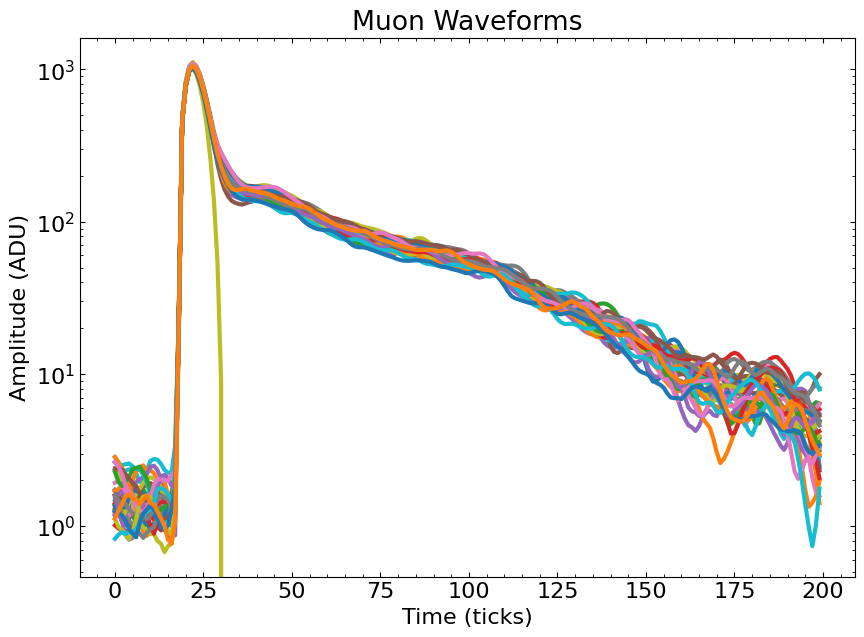

In [73]:
fig, ax = plt.subplots(figsize =(10, 7))
for i in muon_tavg:
    ax.plot(i)
ax.set_title("Muon Waveforms")
ax.set_xlabel("Time (ticks)")
ax.set_ylabel("Amplitude (ADU)")
plt.yscale("log")
#ax.set_ylim(1900, 2100)
#ax.set_xlim(0,200)
plt.show()

In [74]:
with open('muon_arr','wb') as hum:
    pickle.dump(muon_arr,hum) 

In [75]:
with open('muon_tavg','wb') as hmm:
    pickle.dump(muon_tavg,hmm) 